## Проведение АВ-теста

Необходимо проанализировать результаты эксперимента, которые были проведены вместе с командой дата сайентистов. Эксперимент проходил с 2023-01-31 по 2023-02-06 включительно. Для эксперимента были задействованы 2 и 1 группы. В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.

## 1. Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import pandahouse as ph
import random

### 2. Выгрузка данных по условию

In [2]:
# функция для изучения общей информации о датасетах
def general_information(data):
    data.info()
    print()
    display(data.head())
    print()
    print('Дубликатов', data.duplicated().sum(), 'или', round(data.duplicated().sum() / len(data) * 100), '%')

In [3]:
# функция для выполнения запосов
def select(q):
    return ph.read_clickhouse(q, connection=connection)

In [4]:
def ttest(alfa, data_1, data_2, column):
    alpha = alfa # критический уровень статистической значимости
    results = st.ttest_ind(data_1[column], 
           data_2[column], equal_var = False)
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [5]:
def test_mannwhitneyu(alfa, data_1, data_2, column):
    alpha = alfa # критический уровень статистической значимости
    results = st.mannwhitneyu(data_1[column], 
           data_2[column], alternative = 'two-sided')
    print('p-значение:', results.pvalue)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [6]:
# устанавливаем параметры
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230220'
}

In [7]:
# Выгрузка данных по условию: '2022-01-31' по '2023-02-06' и 2 и 1 экспериментальные группы
query = '''
select distinct t1.user_id as iser_id, CTR, exp_group from
(select user_id,
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes,
       countIf(user_id, action = 'like') / countIf(user_id, action='view') as CTR
from {db}.feed_actions 
group by user_id 
having  toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06' and exp_group in (1,2)
order by views desc) t2
join 
(select user_id, exp_group from {db}.feed_actions) t1
using user_id

'''

In [8]:
df_group = select(query)  # сохраняем данныe по условию: '2022-01-24' по '2023-01-30' и 1 и 2 экспериментальных групп

In [9]:
general_information(df_group)  # изучим общую информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20031 entries, 0 to 20030
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   iser_id    20031 non-null  uint32 
 1   CTR        20031 non-null  float64
 2   exp_group  20031 non-null  int8   
dtypes: float64(1), int8(1), uint32(1)
memory usage: 254.4 KB



,iser_id,CTR,exp_group
0,132276,0.093458,2
1,130522,0.081250,2
2,111930,0.122186,1
3,24486,0.154605,1
4,132375,0.102310,2



Дубликатов 0 или 0 %


С датафреймом все хорошо, можно работать

### 3. Проверка гипотез

In [10]:
df_group.groupby(['exp_group']).agg({'iser_id':'count'})

,iser_id
exp_group,
1,10079
2,9952


В одной выборке 10079 наблюдений, в другой 9952, можно считать, что одинаковое количество,  укажем критический уровень статистической значимости - 0.05

#### 3.1. Проверка гипотез на исходных данных

Найдем дисперсии двух выборок. Параметре equal_var, который передается на вход в st.ttest_ind и принимает значение True, если дисперсии выборок равны, и False, если не равны.

In [11]:
var1 = np.var(df_group.query('exp_group == 1')['CTR'], ddof=1)

In [12]:
var2 = np.var(df_group.query('exp_group == 2')['CTR'], ddof=1)

In [13]:
print('Дисперсия группы 1:', var1)

Дисперсия группы 1: 0.0070828247094791436


In [14]:
print('Дисперсия группы 2:', var2)

Дисперсия группы 2: 0.02078786783139333


#### Используем для проверки гипотезы тест t-test

##### Нулевая гипотеза(Н0) – средние двух выборок равны (средние пользовательские CTR равны), альтернативная гипотеза(Н1) – средние пользовательские CTR 2 и 3 экспериментальной группы различаются.

In [15]:
ttest(0.05, df_group.query('exp_group == 1'), df_group.query('exp_group == 2'), 'CTR')

p-значение: 0.4780623130874935
Не получилось отвергнуть нулевую гипотезу


Принимаем гипотезу, что средние пользовательские CTR экспериментальных груп 1 и 2 одинаковые

#### Используем для проверки гипотезы тест Манна-Уитни

##### Нулевая гипотеза(Н0) – нет статистически значимого различия в средних пользовательских CTR между группами, альтернативная гипотеза(Н1) – разница в средних пользовательских CTR между группами статистически значима.

In [16]:
test_mannwhitneyu(0.05, df_group.query('exp_group == 1'), df_group.query('exp_group == 2'), 'CTR')

p-значение: 6.0376484617779035e-56
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергаем, т.е. разница между группами статистически значима. Можно сделать вывод, что в новом интерфейсе пользователи стали лайкать чаще или реже

#### Вывод
t-test показал, что принимаем гипотезу, что средние пользовательские CTR экспериментальных груп 1 и 2 одинаковые. тест Манна-Уитни - нулевую гипотезу отвергаем, т.е. разница между группами статистически значима. Необходимо прjвести более глубокое исследование полученных результатов

#### 3.2. Исследоание распределения двух групп

##### Проведенные два теста показали разный результат, проведем исследование, построим диаграмму распеределения среднего CTR двух групп

Text(0.5, 1.0, 'Распределения получившихся CTR')

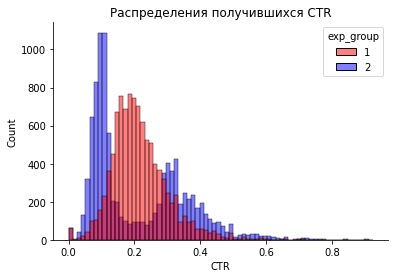

In [17]:
groups = sns.histplot(data = df_group, 
              x='CTR', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
sns.despine()
plt.title('Распределения получившихся CTR')

У второй группы, на которой был использован один из новых алгоритмов рекомендации постов, бимодалное распределение CTR. После применения новых алгоритмов рекомендации постов или совсем мало стали лайкать или очень много, нет зототой середины. У первой группы унимодальное распеределение, т.е. ближе к нормальному

##### Проверим методом st.shapiro(x), можно ли считать эту CTR нормально распределённой в двух группах

In [18]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro( df_group.query('exp_group == 1')['CTR'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


/nfs/env/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [19]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro( df_group.query('exp_group == 2')['CTR'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально') 

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


##### Оценим CTR пользователей ещё одним способом:

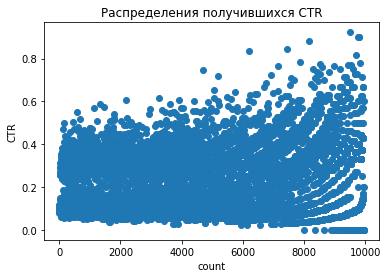

In [20]:
x_values = pd.Series(range(0,len(df_group.query('exp_group == 2')['CTR'])))
plt.scatter(x_values, df_group.query('exp_group == 2')['CTR'])
plt.title('Распределения получившихся CTR')
plt.xlabel('count')
plt.ylabel('CTR')
plt.show()

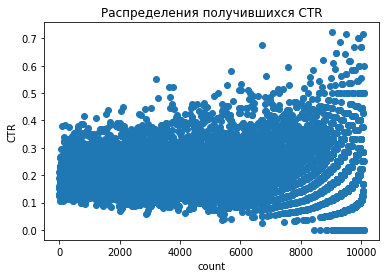

In [21]:
x_values = pd.Series(range(0,len(df_group.query('exp_group == 1')['CTR'])))
plt.scatter(x_values, df_group.query('exp_group == 1')['CTR'])
plt.title('Распределения получившихся CTR')
plt.xlabel('count')
plt.ylabel('CTR')
plt.show()

Обе группы имеют не нормальное распеределение средних CTR

Прсмотрим на динамику CTR во время эксперимента, сравним ее у двух групп

In [22]:
# Выгрузка данных по условию: '2022-01-31' по '2023-02-06' и 2 и 3 экспериментальной группы
query = """
SELECT toString(toDate(time)) as dt,
       countIf(user_id, action = 'like')/countIf(user_id, action = 'view') AS "CTR",
       exp_group      
FROM {db}.feed_actions 
group by dt, exp_group
having toDate(time) >= '2023-01-29' and toDate(time) <= '2023-02-08' and exp_group in (1,2)
"""

In [23]:
df = select(query)

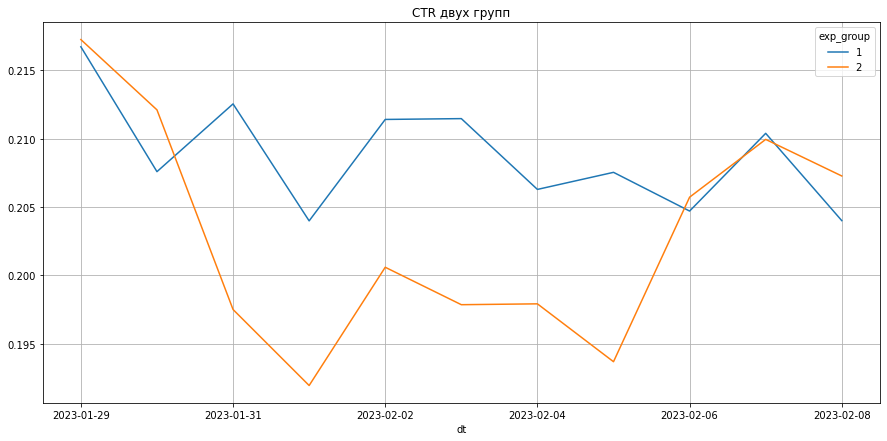

In [24]:
df_plot = df.pivot_table(index = 'dt', columns = 'exp_group', values = 'CTR', aggfunc = 'sum')
df_plot.plot(figsize = (15,7), grid = True)
plt.title('CTR двух групп')
x = df_plot.index 
y = df_plot.values

#### Вывод
У обеих выборок ненормальное распеределение, у второй группы, на которой был использован один из новых алгоритмов рекомендации постов, бимодалное распределение CTR.  У первой группы унимодальное распеределение, т.е. ближе к нормальному.
Эксперимент начался во время падения CTR в обеих группах и затем их динамика была одинаковая и за день до окончания эксперимента резко пошла вверх у группы 2, на которой были применены новые алгоритмы. Вполне возможно, что времени не хватило, чтобы выправилась ситуация с CTRами у группы 2 

#### 3.3. Проверка гипотез на cглаженном CTR

In [25]:
# Выгрузка данных по условию: '2022-01-31' по '2023-02-06' и 2 и 3 экспериментальной группы
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06' and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [26]:
df_group_action = select(query)

In [27]:
# функция для сглаженного CTR  
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

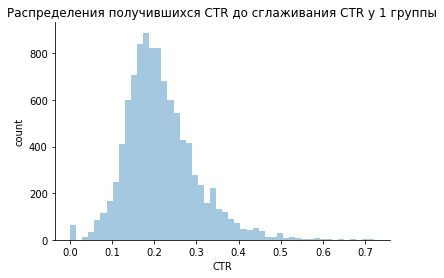

In [30]:
# Найдем среднее CTR в обеих группах
global_ctr_1 = df_group_action[df_group_action.exp_group == 1].likes.sum()/df_group_action[df_group_action.exp_group == 1].views.sum()
global_ctr_2 = df_group_action[df_group_action.exp_group == 2].likes.sum()/df_group_action[df_group_action.exp_group == 2].views.sum()

group1 = df_group_action[df_group_action.exp_group == 1].copy()
sns.distplot(group1.ctr, 
             kde = False)
sns.despine()
plt.title('Распределения получившихся CTR до сглаживания CTR у 1 группы')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

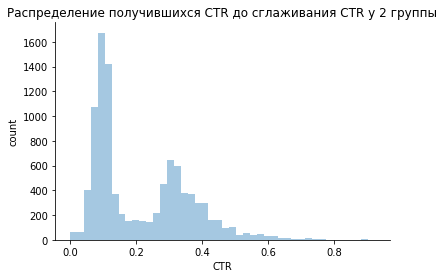

In [31]:
group2 = df_group_action[df_group_action.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)
sns.despine()
plt.title('Распределение получившихся CTR до сглаживания CTR у 2 группы')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

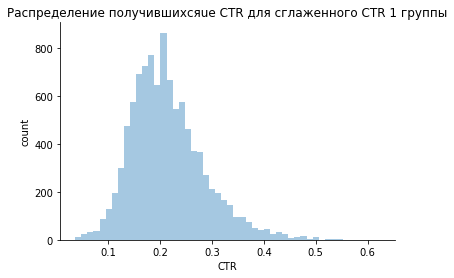

In [32]:
# Сгладим 1 группу с помощью процедуры сглаживания Лапласа
group1['smothed_ctr'] = df_group_action.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)
sns.despine()
plt.title('Распределениe получившихсяue CTR для сглаженного CTR 1 группы')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

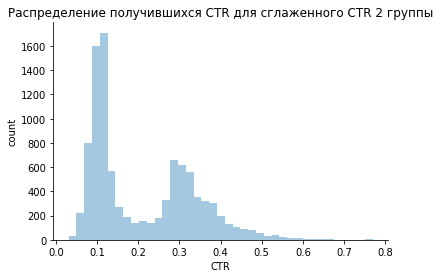

In [33]:
# Сгладим 2 группу с помощью процедуры сглаживания Лапласа и посмотрим распределение
group2['smothed_ctr'] = df_group_action.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)
sns.despine()
plt.title('Распределениe получившихся CTR для сглаженного CTR 2 группы')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

У второй группы распеределение после сгаживания CTR два пика осталось, и у первой по сути ничего не изменилось. кроме тех пользователей, у которых экстримально малый CTR

#### Используем для проверки гипотезы тест t-test на сглаженных CTR

##### Нулевая гипотеза(Н0) – средние двух выборок равны (средние пользовательские CTR равны), альтернативная гипотеза(Н1) – средние пользовательские CTR 2 и 3 экспериментальной группы различаются.

In [34]:
ttest(0.05, group1, group2, 'smothed_ctr')

p-значение: 0.0223769815558559
Отвергаем нулевую гипотезу


##### Отвергаем гипотезу, что средние пользовательские CTR группы 1 и группы 2 одинаковые.

#### Используем для проверки гипотезы тест Манна-Уитни

In [35]:
test_mannwhitneyu(0.05, group1, group2, 'smothed_ctr')

p-значение: 1.6163964114270227e-61
Отвергаем нулевую гипотезу


##### Нулевую гипотезу отвергаем, т.е. разница между группами статистически значима.

#### Вывод: 
После сглаживания CTR  и т-тест показал, что можно отвергнуть нулевую гипотезу

#### 3.4. Пуассоновский бутстреп для подсчета разницы в CTR

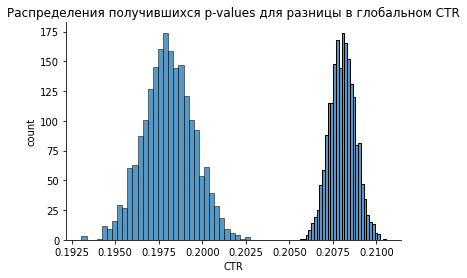

In [36]:
# Функция для подсчета разницы в CTR Пуассоновским бутстрепом:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df_group_action[df_group_action.exp_group == 1].likes.to_numpy()
views1 = df_group_action[df_group_action.exp_group == 1].views.to_numpy()
likes2 = df_group_action[df_group_action.exp_group == 2].likes.to_numpy()
views2 = df_group_action[df_group_action.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)  # применим функцию для подсчета разницы в CTR Пуассоновским бутстрепом
# Отрисуем распределения после преобразований
sns.histplot(ctr1)
sns.histplot(ctr2)
sns.despine()
plt.title('Распределения получившихся p-values для разницы в глобальном CTR')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

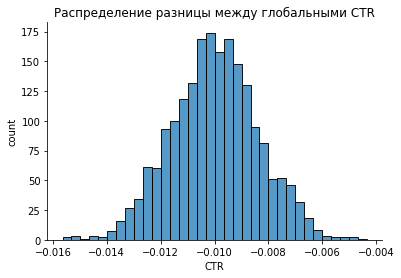

In [37]:
# Отрисуем распределение разницы
sns.histplot(ctr2 - ctr1)
sns.despine()
plt.title('Распределение разницы между глобальными CTR')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

#### Вывод
Видим, что совсем нет пересечений у двух групп пользователей и находится в зоне, которая строго меньше 0, значит средний CTR уменьшился после применнения новых алгоритмов рекомендации постов

#### 3.5.  Проверка гипотез поверх бакетного преобразования

In [38]:
# Выгрузка данных по условию: '2022-01-31' по '2023-02-06' и 2 и 3 экспериментальной группы
query = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr, -- считаем средний CTR в каждом бакете
    quantileExact(0.9)(ctr) as ctr9 -- берем 90 % квантиль в каждом бакете
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket, -- разбиваем на бакеты пользователей
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= '2023-01-31' and toDate(time) <= '2023-02-06' and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

In [39]:
df_group_bucket = select(query)

In [40]:
df_group_bucket

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314
...,...,...,...,...
95,2,47,0.195880,0.426230
96,1,48,0.212787,0.318182
97,2,48,0.194502,0.409091
98,1,49,0.203169,0.325581


#### Проверки гипотез t-test и тестом Манна-Уитни

Проведем тесты, сравнивая после бакетного преобразования, где были посчитаны средние CTR в каждом бакете

##### Нулевая гипотеза(Н0) – средние двух выборок равны (средние пользовательские CTR равны), альтернативная гипотеза(Н1) – средние пользовательские CTR 2 и 3 экспериментальной группы различаются.

In [41]:
ttest(0.05, df_group_bucket[df_group_bucket.exp_group == 1], df_group_bucket[df_group_bucket.exp_group == 2], 'bucket_ctr')

p-значение: 3.4455951649945907e-07
Отвергаем нулевую гипотезу


##### Нулевая гипотеза(Н0) – нет статистически значимого различия в средних пользовательских CTR между группами, альтернативная гипотеза(Н1) – разница в средних пользовательских CTR между группами статистически значима.¶

In [42]:
test_mannwhitneyu(0.05, df_group_bucket[df_group_bucket.exp_group == 1], df_group_bucket[df_group_bucket.exp_group == 2], 'bucket_ctr')

p-значение: 2.859963936492646e-07
Отвергаем нулевую гипотезу


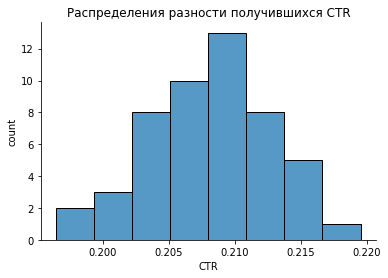

In [44]:
sns.histplot(df_group_bucket[df_group_bucket.exp_group == 1].bucket_ctr)
sns.despine()
plt.title('Распределения разности получившихся CTR')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

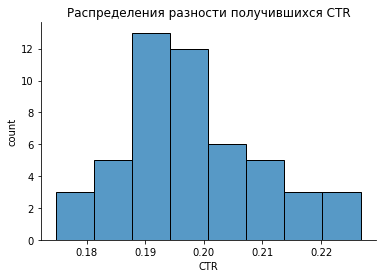

In [45]:
sns.histplot(df_group_bucket[df_group_bucket.exp_group == 2].bucket_ctr)
sns.despine()
plt.title('Распределения разности получившихся CTR')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

#### Проведем тесты сравнивая бакеты с 90% квантилями

##### Нулевая гипотеза(Н0) – средние двух выборок равны (средние пользовательские CTR равны), альтернативная гипотеза(Н1) – средние пользовательские CTR 2 и 3 экспериментальной группы различаются.

In [46]:
ttest(0.05, df_group_bucket[df_group_bucket.exp_group == 1], df_group_bucket[df_group_bucket.exp_group == 2], 'ctr9')

p-значение: 1.2945537024964474e-40
Отвергаем нулевую гипотезу


##### Нулевая гипотеза(Н0) – нет статистически значимого различия в средних пользовательских CTR между группами, альтернативная гипотеза(Н1) – разница в средних пользовательских CTR между группами статистически значима.

In [47]:
test_mannwhitneyu(0.05, df_group_bucket[df_group_bucket.exp_group == 1], df_group_bucket[df_group_bucket.exp_group == 2], 'ctr9')

p-значение: 6.344839189967265e-18
Отвергаем нулевую гипотезу


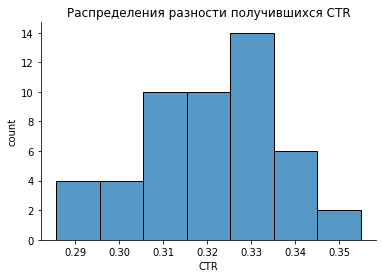

In [48]:
sns.histplot(df_group_bucket[df_group_bucket.exp_group == 1].ctr9)
sns.despine()
plt.title('Распределения разности получившихся CTR')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

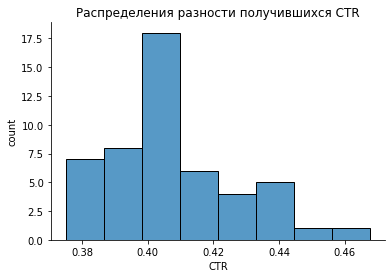

In [49]:
sns.histplot(df_group_bucket[df_group_bucket.exp_group == 2].ctr9)
sns.despine()
plt.title('Распределения разности получившихся CTR')
plt.xlabel('CTR')
plt.ylabel('count')
plt.show()

#### Вывод
Распределения у групп после бакетного преобразования стали более нормальными, особенно у 2 группы пользователей, но все равно отвергаем нулевую гипотезу и опять во всех случаях отвергаем нулевую гипотезу

### Общий вывод
Если рассматривать графические представления распределений средних CTR в группах и после применения теста Шапиро-Уилка, понимаем, что они не нормальные. Бимодальность группы, где был применен новые алгоритмы рекомендации постов, может быть связано стем, что аудитория разделилась на две группы, которым изменения очень зашли и которым совсем не зашли, при чем у вторых средние CTR кучно находятся в районе значения 0,1
Разница в средних CTR имеется, но только не в лучшую сторону для группы No2
Почему такое могло произойти? Может эти рекомендации получились ориентированные на более взрослую публику или наоборот, а может изменения повлияли именно на аудиторию, которую мало лайкает? Хотели выправить ситуацию, привлечь последних к действию под название "лайк".
Еще одна гипотеза: не хватило времени для выправления ситуации, возможно, что через несколько дней ситуация бы улучшилась
Возможно имеет смысл рассмотреть возможность продлить эксперимент
